#### Data Loading

In [76]:
import os
import numpy as np
import pandas as pd
import pickle
import lightgbm as lgb
#from lightgbm import LGBMRegressor  # sckit에서 lightgbm을 wrapping한 것
from sklearn.model_selection import train_test_split
import datetime
from sklearn.metrics import root_mean_squared_error
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import Utility as Util

########
file_path = '/root/Bytelee_data/CodingSpace/2024_AI_BEMS/DATA_YiUmGO/data_colec_h_202509091411_B0019.csv'
#########
df_buildID = pd.read_csv(file_path)
df_buildID['colec_dt'] = pd.to_datetime(df_buildID['colec_dt']).dt.floor('min')  # 분 이하는 제거
print(f"timestamp(first~last): {df_buildID['colec_dt'].iloc[0]} ~ {df_buildID['colec_dt'].iloc[-1]}")
print(f"timestamp(min~max):    {df_buildID['colec_dt'].min()} ~ {df_buildID['colec_dt'].max()}")

start_date, end_date = pd.to_datetime('2025-03-24 17:45:00'), pd.to_datetime('2025-09-09 14:05:00')

df_raw_all = df_buildID[(df_buildID['colec_dt'] >= start_date) & (df_buildID['colec_dt'] <= end_date)]

timestamp(first~last): 2025-03-24 17:45:00 ~ 2025-09-09 14:05:00
timestamp(min~max):    2025-03-24 17:45:00 ~ 2025-09-09 14:05:00


#### devID, tagCD extraction

In [77]:
# 관찰 구간
#devID==6001~6083, 6085~6149 "에어컨", tagCD==?????? '??????', anomaly_detection(), vacation_detection(), optimal_control()
#100001	운전선택탭  off: 0, on: 1  <-- 이산치인데 데이터누락이 많음
#100002	냉난방모드	cool: 0, heat: 1, dry: 2, fan: 3, auto: 4, normal: 5, env: 6, sleep: 6
#100003	현재온도	현재온도
#100004	희망온도	냉방 18.0~30.0, 난방 16.0~30.0
#100005	풍량        low: 0, med: 1, mid: 1, high: 2, auto: 3
#100006	리모컨허용  level: 2, true: 1, false: 0
#100007	에러	    indoor: 0, outdoor: 1, caur: 2, trans: 3

######
devID, device_name = 6095, '교직원휴게실남'
######

Util.print_tagCD(df_raw_all, devID)
tag_dict = {100001: '운전선택탭', 100002: '냉난방모드', 100003: '현재온도', 100004: '희망온도'}
# dictionary를 이용해 각 태그 데이터를 선택
tags = {key: Util.select_devID_tagCD(df_raw_all, devID, tagCD=key) for key in tag_dict.keys()}
# 특정 태그에 대해 추가 연산 수행 (예: 전체누적사용량 차이 계산)
#tags[90004] = calc_tagCD_diff(tags[90004])

# 그래프를 그리기 위해 필요한 데이터를 리스트로 변환
tag_data = [tags[key] for key in tag_dict.keys()]
tag_names = [tag_dict[key] for key in tag_dict.keys()]

Util.plot_dfL_devID_tagCD(tag_data, tag_names, device_name, createFig=False, W=None, H=600)

tagCD list:  [202202 100007 100005 100002 100001 100006 100003 100004]


#### Step A. Feature Engineering, lightGBM Modeling
  - LightGBM은 tree-based 모델로 scaling을 특별히 요구하지 않음
  - Prediction model 일 때는, 과거 데이터 정보(X)로만 현재 데이터(y)를 Regression 할 수 있도록 함
  - 일반적인 Regression model 일 때는, 타 데이터의 현재 데이터(X)를 사용해도 됨
  - 참고로, LSTM은 (t-k, ..., t-1) ---> t 에서 별도의 feature engineering을 수행하지 않음 
  - train_test_split() 에서, prediction model에서는 shuffle=False, regression model에서는 shuffle=True

In [78]:
%load_ext autoreload
%autoreload 2

# 환경 온도 구하는 루틴

import Aircon_DataProcessing as DP

df_offON_raw = pd.DataFrame(data=tag_data[0]['colec_val'].values, index=tag_data[0]['colec_dt'], columns=['value'])
df_coolHeat_raw = pd.DataFrame(data=tag_data[1]['colec_val'].values, index=tag_data[1]['colec_dt'], columns=['value'])
df_tCur_raw = pd.DataFrame(data=tag_data[2]['colec_val'].values, index=tag_data[2]['colec_dt'], columns=['value'])
df_tSet_raw = pd.DataFrame(data=tag_data[3]['colec_val'].values, index=tag_data[3]['colec_dt'], columns=['value'])

# 음수 보정 --> 음수는 결측치로 처리하고, 이후 한꺼번에 보간 처리
df_offON_raw.loc[df_offON_raw['value'] < 0, 'value'] = np.nan
df_coolHeat_raw.loc[df_coolHeat_raw['value'] < 0, 'value'] = np.nan
df_tCur_raw.loc[df_tCur_raw['value'] < 0, 'value'] = np.nan
df_tSet_raw.loc[df_tSet_raw['value'] < 0, 'value'] = np.nan

# zero가 연속된 구간을 찾아서 리스트로 저장
df_tCur_zero, _, _, _ = DP.preprocess(df_tCur_raw, points=4, freqInterval='15min', only_cleansing=True, fill_method='zero')
zero_sequence_intervals = DP.find_zero_sequence_intervals(df_tCur_zero, min_zero_streak=4*1)  # 0이 1시간 이상 연속된 구간 찾기

# df_offON 선형 보간
df_offON, df_offON_is_missing, df_offON_nan_counts_df, df_offON_missing_ratio = DP.preprocess(df_offON_raw, points=4, freqInterval='15min', only_cleansing=True, fill_method='time')  # 시간 고려 선형 보간
df_offON.loc[df_offON['value'] > 0, 'value'] = 1
# df_offON.value가 0을 유지하다가 1로 올라가는 지점을 ON으로 추가 설정
df_offON['value'] = df_offON['value'].mask((df_offON['value'] == 0) & (df_offON['value'].shift(-1) == 1), 1)
# df_offON.value가 1를 유지하다가 0로 떨어지는 지점을 ON으로 추가 설정
df_offON['value'] = df_offON['value'].mask((df_offON['value'] == 0) & (df_offON['value'].shift(1) == 1), 1)

df_coolHeat, df_coolHeat_is_missing, df_coolHeat_nan_counts_df, df_coolHeat_missing_ratio = DP.preprocess(df_coolHeat_raw, points=4, freqInterval='15min', only_cleansing=True, fill_method='time')  # 시간 고려 선형 보간
df_tCur, df_tCur_is_missing, df_tCur_nan_counts_df, df_tCur_missing_ratio = DP.preprocess(df_tCur_raw, points=4, freqInterval='15min', only_cleansing=True, fill_method='time')  # 시간 고려 선형 보간
df_tSet, df_tSet_is_missing, df_tSet_nan_counts_df, df_tSet_missing_ratio = DP.preprocess(df_tSet_raw, points=4, freqInterval='15min', only_cleansing=True, fill_method='time')  # 시간 고려 선형 보간

#  df_offON_virtual 생성
df_offON_virtual = DP.generate_df_offON_virtual(df_tCur, df_coolHeat, df_offON)
df_offON_adj = df_offON.copy()
df_offON_adj['value'] = ((df_offON['value'] > 0) | (df_offON_virtual['value'] > 0)).astype(int)

# Generate tEnv from df_tCur and df_offON_adj
df_tEnv = DP.generate_tEnv_from_df_tCur(df_tCur, df_offON_adj)
#legendList = ['offON_adj', 'offON_mask', 'tCur', 'tEnv']
#Util.plot_dfList_devID_tagCD([df_offON_adj+20, df_offON_mask+18, df_tCur, df_tEnv], legendList, device_name, createFig=True, W=None, H=600)

# zero_sequence_intervals 구간을 적용하여 보정
for start_time, end_time in zero_sequence_intervals:
    df_offON.loc[start_time:end_time, 'value'] = 0
    df_offON_virtual.loc[start_time:end_time, 'value'] = 0
    df_offON_adj.loc[start_time:end_time, 'value'] = 0
    #df_coolHeat.loc[start_time:end_time, 'value'] = 0
    df_tCur.loc[start_time:end_time, 'value'] = 0
    df_tEnv.loc[start_time:end_time, 'value'] = 0
    df_tSet.loc[start_time:end_time, 'value'] = 0

#####
start_date, end_date = '2025-03-24 17:45:00', '2025-09-09 14:05:00'
#####

df_offON_sliced = df_offON[(df_offON.index >= start_date) & (df_offON.index <= end_date)]
df_offON_virtual_sliced = df_offON_virtual[(df_offON_virtual.index >= start_date) & (df_offON_virtual.index <= end_date)]
df_offON_adj_sliced = df_offON_adj[(df_offON_adj.index >= start_date) & (df_offON_adj.index <= end_date)]

df_coolHeat_sliced = df_coolHeat[(df_coolHeat.index >= start_date) & (df_coolHeat.index <= end_date)]
df_tCur_sliced = df_tCur[(df_tCur.index >= start_date) & (df_tCur.index <= end_date)]
df_tEnv_sliced = df_tEnv[(df_tEnv.index >= start_date) & (df_tEnv.index <= end_date)]
df_tSet_sliced = df_tSet[(df_tSet.index >= start_date) & (df_tSet.index <= end_date)]

legendList = ['offON', 'offON_virtual', 'offON_adj', 'coolHeat', 'tCur', 'tEnv', 'tSet']
Util.plot_dfList_devID_tagCD([df_offON_sliced+18, df_offON_virtual_sliced+18, df_offON_adj_sliced+18, df_coolHeat_sliced, df_tCur_sliced, df_tEnv_sliced, df_tSet_sliced], legendList, device_name, createFig=False, W=None, H=600)
#Util.plot_dfList_devID_tagCD([df_offON_adj], ['offON_adj'], device_name, createFig=True, W=None, H=None)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Prediction - offON_adj

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
timestamp: 2025-04-03 19:30:00, 2025-09-09 14:00:00
nan_counts max= 677, missing_ratio= 0.0
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[40]	validation's binary_logloss: 0.0104096
Experiment A: accuracy_a= 0.995, rmse_a= 0.057 with 61 features


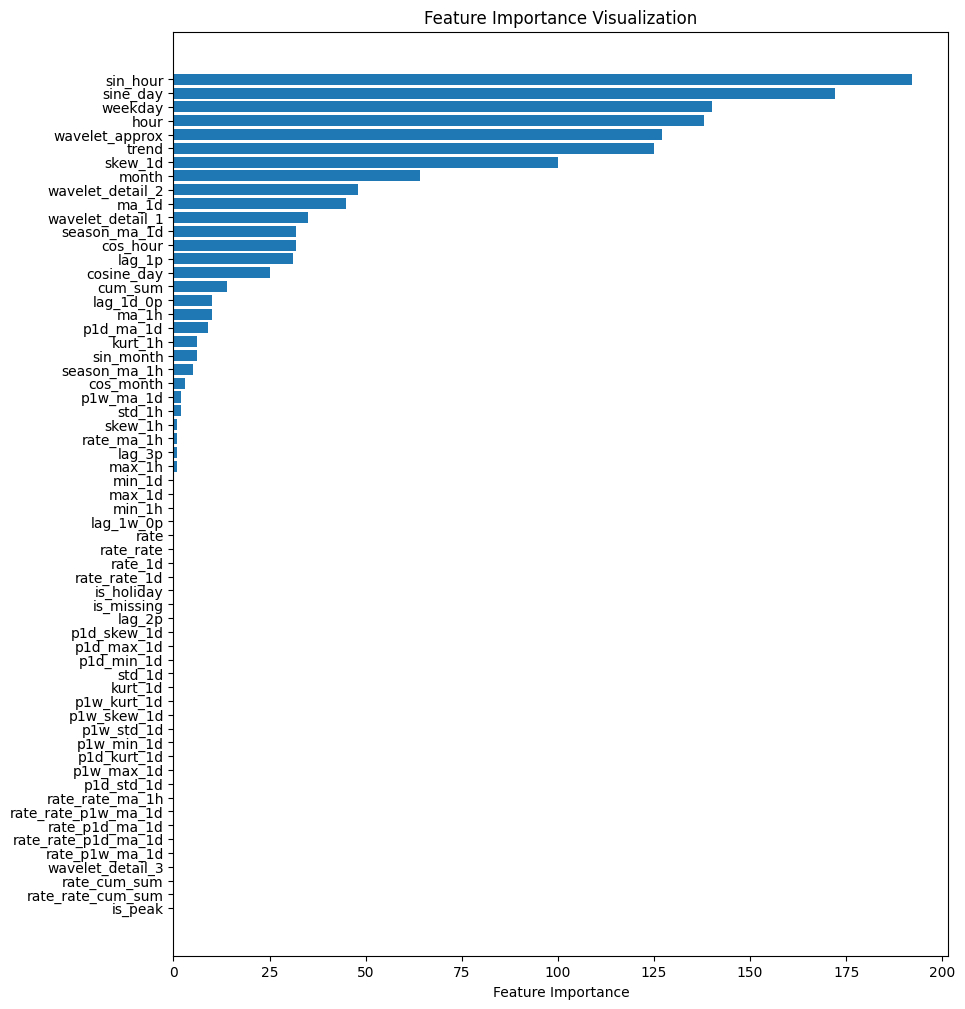

In [79]:
%load_ext autoreload
%autoreload 2

from sklearn.metrics import accuracy_score
import Aircon_DataProcessing as DP

#df_raw = pd.DataFrame(data=tag_data[0]['colec_val'].values, index=tag_data[0]['colec_dt'], columns=['value'])
#df_raw = df_raw.iloc[int(len(df_raw)/2-1500):-1].copy()

df_raw = df_offON_adj
print(f"timestamp: {df_raw.index[0]}, {df_raw.index[-1]}")
#df_interpol = Util.resample_time_index_interpolate_NaN_df(df_raw, '15min', 'linear')
#Util.plot_interpolated_data(df_raw, df_interpol, device_name, createFig=True)
#Util.plot_data(df_raw, plotType='simple', title=None, W=10, H=5)

X_df, y_df, nan_counts_df, missing_ratio = DP.preprocess(df_raw, points=4, freqInterval='15min')
print(f"nan_counts max= {nan_counts_df.max()}, missing_ratio= {missing_ratio}")

# 학습 및 테스트 데이터 분할
# 시계열 데이터는 시간 순으로 되어 있어야 하고, shuffle=False로 순방향 데이터검증 보장
X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.3, random_state=42, shuffle=False)
#train_size = int(len(X) * 0.8)
#X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
#y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

# LightGBM 데이터 세트 생성
train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# 모델 하이퍼파라미터 설정
params = {
    'objective': 'binary',  # binary classification
    'metric': 'binary_logloss',  # binary metric
    'boosting_type': 'gbdt',
    'learning_rate': 0.1,
    'num_leaves': 50,
    'verbose': -1
}

# 모델 학습
model_a = lgb.train(params,
                    train_data,
                    valid_sets=[valid_data],
                    num_boost_round=1000,
                    valid_names=['validation'],
                    callbacks=[lgb.early_stopping(stopping_rounds=30)])

##################
# 예측 수행
y_pred_a = model_a.predict(X_test, num_iteration=model_a.best_iteration)
y_pred_a_binary = np.where(y_pred_a < 0.5, 0, 1)  # 0.5를 기준으로 이진분류 변환 
accuracy_a = accuracy_score(y_test, y_pred_a_binary)
rmse_a = root_mean_squared_error(y_test, y_pred_a)
print(f'Experiment A: {accuracy_a= :.3f}, {rmse_a= :.3f} with {X_df.shape[1]} features')

# 예측 결과 시각화
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_raw.index, y=df_raw['value'], mode='lines', name='Actual Value'))
fig.add_trace(go.Scatter(x=y_test.index, y=y_test, mode='lines', name='Cleaned Value'))
fig.add_trace(go.Scatter(x=y_test.index, y=y_pred_a_binary-0.02, mode='lines', name='Predicted Value'))

# Update layout
fig.update_layout(title=f'Aircon offON Prediction, {devID}, {device_name}',
                  xaxis_title='Date',
                  yaxis_title='Values',
                  legend_title='Legend',
                  legend=dict(x=0.02, y=0.98, xanchor='left', yanchor='top', orientation='v')
                  )
fig.show()

# Feature Importance Visualization
# 모델의 특성 중요도 추출
feature_importances = model_a.feature_importance()
feature_names = X_df.columns

# 특성 중요도를 데이터프레임으로 정리
importance_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
importance_df = importance_df.sort_values(by='importance', ascending=False)

# 특성 중요도 시각화
plt.figure(figsize=(10, 12))  # 그래프 크기 설정
plt.barh(importance_df['feature'], importance_df['importance'])  # 수평 막대그래프 생성
plt.xlabel('Feature Importance')  # x축 레이블 설정
plt.title('Feature Importance Visualization')  # 그래프 제목 설정
plt.gca().invert_yaxis()  # 중요도가 높은 순으로 표시
plt.show()  # 그래프 출력

#### Save the model & Run Inference

In [80]:
#devID, tagCD = devID, list(tag_dict.keys())[0]
file_path_AI_model = f"/root/Bytelee_data/CodingSpace/2024_AI_BEMS/DATA_YiUmGO/{devID}_{device_name}_Aircon_offON_Prediction_LGBM.txt"

print(f'{file_path_AI_model= }')
model_a.save_model(file_path_AI_model)
#model_opt.save_model(file_path_AI_model)

# 모델 로드
model_infer = lgb.Booster(model_file=file_path_AI_model)

# 예측 수행 (로드된 모델 사용)
y_pred_a = model_infer.predict(X_test, num_iteration=model_a.best_iteration)

# 모델 평가
y_pred_a_binary = np.where(y_pred_a < 0.5, 0, 1)  # 0.5를 기준으로 이진분류 변환 
accuracy_a = accuracy_score(y_test, y_pred_a_binary)
rmse_a = root_mean_squared_error(y_test, y_pred_a)
print(f'Experiment A: {accuracy_a= :.3f}, {rmse_a= :.3f} with {X_df.shape[1]} features')

# 예측 결과 시각화
fig = go.Figure()

# Add traces for values
fig.add_trace(go.Scatter(x=y_test.index, y=y_test, mode='lines', name='Cleaned Value'))
fig.add_trace(go.Scatter(x=y_test.index, y=y_pred_a_binary-0.02, mode='lines', name='Predicted Value'))

# Update layout with secondary y-axis
fig.update_layout(
    title=f'Aircon offON Prediction, {devID}, {device_name}', 
    xaxis_title='Date',
    yaxis_title='Values',
    yaxis=dict(
        range=[0, 2]
    ),
    legend=dict(x=0.02, y=0.98, xanchor='left', yanchor='top', orientation='v')
)
fig.show()

file_path_AI_model= '/root/Bytelee_data/CodingSpace/2024_AI_BEMS/DATA_YiUmGO/6095_교직원휴게실남_Aircon_offON_Prediction_LGBM.txt'
Experiment A: accuracy_a= 0.995, rmse_a= 0.057 with 61 features
